In [1]:
# import gymnasium as gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt
import sys
import copy
%matplotlib inline

In [2]:
import sys
sys.path.append('../models/simulator_and_related_models/')
from env import simulator

In [3]:
def reward(self, penalty, action):
    extra = 0
    if self.done == 1 and self.correct_solution == 0:
        extra = -8
    if action == 2:
        penalty = -5
    return self.prob_count * 13 + self.listen_to_feedback_count * 10 + extra + penalty + self.convo_turn + self.progress_delta

env = simulator(reward)

In [4]:
# Replay buffer
class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )

# policy evaluation with Monte Carlo
def eval_policy(policy, env_name, seed, eval_episodes=10):
        def reward(self, penalty, action):
            extra = 0
            if self.done == 1 and self.correct_solution == 0:
                extra = -8
            if action == 2:
                penalty = -5
            return self.prob_count * 13 + self.listen_to_feedback_count * 10 + extra + penalty + self.convo_turn + self.progress_delta

        env = simulator(reward)
        env.reset()
        eval_env = env
        avg_reward = 0.
        for _ in range(eval_episodes):
            state, _ = eval_env.reset()
            done = False
            step = 0
            while not done:
                action = policy.select_action(np.array(state))
                state, reward, terminated, truncated, _ = eval_env.step(action)
                avg_reward += reward
                step += 1
                done = terminated or truncated
        avg_reward /= eval_episodes

        print("---------------------------------------")
        print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
        print("---------------------------------------")
        return avg_reward


In [5]:
LOG_STD_MIN = -20
LOG_STD_MAX = 2
epsilon = 1e-6

class Actor_SAC(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor_SAC, self).__init__()
        # [HINT] Construct a neural network as the actor. Return its value using forward You need to write down three linear layers.
        # 1. l1: state_dim → 256
        # 2. l2: 256 → 256
        # 3. l3: 256 → mean and log std of the action
        ############################
        # YOUR IMPLEMENTATION HERE #
        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        
        self.l3_mean = nn.Linear(256, 1) # mean and log std of the action
        self.l3_log_std = nn.Linear(256, 1) # mean and log std of the action
        ############################
        self.max_action = max_action

    def forward(self, state):
        # [HINT] Use the three linear layers to compute the mean and log std of the action
        # Apply ReLU activation after layer l1 and l2
        ############################
        # YOUR IMPLEMENTATION HERE #
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))

        mean = self.l3_mean(a)
        log_std = self.l3_log_std(a)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)
        ############################
        log_std = torch.clamp(log_std, min=LOG_STD_MIN, max=LOG_STD_MAX)
        return mean, log_std

    def sample(self, state):
        # [HINT] Use the forward method to compute the action, its log probability
        # 1. Compute the mean and log std of the action
        # 2. Compute the standard deviation of the action
        # 3. Get the normal distribution of the action
        # 4. Sample the action from the normal distribution
        # 5. Apply tanh to the action and multiply by max_action to ensure the action is in the range of the action space
        # 6. Compute the log probability of the action
        
        ############################
        # YOUR IMPLEMENTATION HERE #
        # 1. Compute the mean and log std of the action
        mean, log_std = self.forward(state)
        # 2. Compute the standard deviation of the action
        std = log_std.exp()
        # 3. Get the normal distribution of the action
        normal = torch.distributions.Normal(mean, std)
        # 4. Sample the action from the normal distribution
        x_t = normal.rsample()
        # 5. Apply tanh to the action and multiply by max_action to ensure the action is in the range of the action space
        y_t = torch.tanh(x_t)
        action = y_t * self.max_action
        # 6. Compute the log probability of the action
        log_prob = normal.log_prob(x_t)
        log_prob -= torch.log(self.max_action * (1 - y_t.pow(2)) + epsilon)
        log_prob = log_prob.sum(1, keepdim=True)
        ############################
        return action, log_prob

class Critic_SAC(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic_SAC, self).__init__()
        # Q1 architecture
        # [HINT] Construct a neural network as the first critic. Return its value using forward You need to write down three linear layers.
        # 1. l1: state_dim+action_dim → 256
        # 2. l2: 256 → 256
        # 3. l3: 256 → 1
        ############################
        # YOUR IMPLEMENTATION HERE #
        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)
        ############################

        # Q2 architecture
        # [HINT] Construct a neural network as the second critic. Return its value using forward. You need to write down three linear layers.
        # 1. l4: state_dim+action_dim → 256
        # 2. l5: 256 → 256
        # 3. l6: 256 → 1
        ############################
        # YOUR IMPLEMENTATION HERE #
        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 256)
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)
        ############################


    def forward(self, state, action):
        sa = torch.cat([state, action], 1)
        # [HINT] We use layers l1, l2, l3 to obtain q1
        # 1. Apply ReLU activation after layer l1
        # 2. Apply ReLU activation after layer l2
        # 3. Return output as q1 from layer l3

        # [HINT] We use layers l4, l5, l6 to obtain q2
        # 1. Apply ReLU activation after layer l4
        # 2. Apply ReLU activation after layer l5
        # 3. Return output as q2 from layer l6

        ############################
        # YOUR IMPLEMENTATION HERE #
        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        ############################
        return q1, q2


    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)
        # [HINT] only returns q1 for actor update using layers l1, l2, l3
        # 1. Apply ReLU activation after layer l1
        # 2. Apply ReLU activation after layer l2
        # 3. Return output as q1 from layer l3
        ############################
        # YOUR IMPLEMENTATION HERE #
        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        ############################
        return q1

class SAC(object):
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        alpha=0.2,
    ):
        self.actor = Actor_SAC(state_dim, action_dim, max_action).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

        self.critic = Critic_SAC(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.alpha = alpha

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        action, _ = self.actor.sample(state)
        return action.detach().cpu().numpy().flatten()

    def train(self, replay_buffer, batch_size=256):
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        # [HINT] compute the target Q value
        # 1. Sample the next action and its log probability from the actor with next_state
        # 2. Compute the next Q values (Q1 and Q2) using the critic_target with next_state and next_action
        # 3. Min over the Q values: target_Q = min(Q1, Q2) - log_prob(a'|s') * alpha
        # 4. Compute the target Q value: target_Q = reward + not_done * discount * target_Q

        ############################
        # YOUR IMPLEMENTATION HERE #
        # 1. Sample the next action and its log probability from the actor with next_state
        next_action, next_log_prob = self.actor.sample(next_state)
        # 2. Compute the next Q values (Q1 and Q2) using the critic_target with next_state and next_action
        q1_next_target, q2_next_target = self.critic_target(next_state, next_action)
        # 3. Min over the Q values: target_Q = min(Q1, Q2) - log_prob(a'|s') * alpha
        target_Q = torch.min(q1_next_target, q2_next_target) - next_log_prob * self.alpha
        # 4. Compute the target Q value: target_Q = reward + not_done * discount * target_Q
        target_Q = reward + not_done * self.discount * target_Q
        
        target_Q = target_Q.detach()

        # critic loss
        q1, q2 = self.critic(state, action)
        q1_loss = F.mse_loss(q1, target_Q)
        q2_loss = F.mse_loss(q2, target_Q)
        critic_loss = q1_loss + q2_loss
        ############################

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # [HINT] compute the actor loss
        # 1. Sample the action and its log probability from the actor with state
        # 2. Compute the Q values (Q1 and Q2) using the critic with state and action
        # 3. Min over the Q values: Q = min(Q1, Q2)
        # 4. Compute the actor loss: actor_loss = alpha * log_prob(a|s) - Q

        ############################
        # YOUR IMPLEMENTATION HERE #
        # 1. Sample the action and its log probability from the actor with state
        action, log_prob = self.actor.sample(state)
        # 2. Compute the Q values (Q1 and Q2) using the critic with state and action
        q1, q2 = self.critic(state, action)
        # 3. Min over the Q values: Q = min(Q1, Q2)
        Q = torch.min(q1, q2)
        # 4. Compute the actor loss: actor_loss = alpha * log_prob(a|s) - Q
        actor_loss = (self.alpha * log_prob - Q).mean() # for batch
        ############################

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


In [6]:
def init_flags():

        flags = {
                "env": "Pendulum-v1",
                "seed":0,
                "start_timesteps": 2e4,
                "max_timesteps": 5e4,
                "expl_noise": 0.01,
                "batch_size": 256,
                "discount":0.99,
                "tau": 0.005,
                "policy_noise": 0.05,
                "noise_clip":0.5,
                "policy_freq": 2,
                "save_model": "store_true"
        }

        return flags

def main(policy_name = 'TD3'):

        args = init_flags()

        def reward(self, penalty, action):
            extra = 0
            if self.done == 1 and self.correct_solution == 0:
                extra = -8
            if action == 2:
                penalty = -5
            return self.prob_count * 13 + self.listen_to_feedback_count * 10 + extra + penalty + self.convo_turn + self.progress_delta

        env = simulator(reward)
        env.reset()
        torch.manual_seed(args["seed"])
        np.random.seed(args["seed"])

        state_dim = 7
        action_dim = 1
        max_action = float(3)
        kwargs = {
                "state_dim": state_dim,
                "action_dim": action_dim,
                "max_action": max_action,
                "discount": args["discount"],
                "tau": args["tau"],}
        if policy_name == "TD3":
                # Target policy smoothing is scaled wrt the action scale
                kwargs["policy_noise"] = args["policy_noise"] * max_action
                kwargs["noise_clip"] = args["noise_clip"] * max_action
                kwargs["policy_freq"] = args["policy_freq"]
                policy = TD3(**kwargs)
        elif policy_name == "SAC":
                policy = SAC(**kwargs)

        replay_buffer = ReplayBuffer(state_dim, action_dim)
        evaluations = [eval_policy(policy, env, args["seed"])]
        state, _ = env.reset()
        done = False
        episode_reward = 0
        episode_timesteps = 0
        episode_num = 0

        for t in range(int(args["max_timesteps"])):
            episode_timesteps += 1

            # Select action randomly or according to policy
            if t < args["start_timesteps"]:
                action = np.random.choice(env.action_space)
            else:
                action = (
                    policy.select_action(np.array(state))
                    + np.random.normal(0, max_action * args["expl_noise"], size=action_dim)
                ).clip(-max_action, max_action)

            # Perform action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated
            done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

            # Store data in replay buffer
            replay_buffer.add(state, action, next_state, reward, done_bool)

            state = next_state
            episode_reward += reward

            # Train agent after collecting sufficient data
            if t >= args["start_timesteps"]:
                policy.train(replay_buffer, args["batch_size"])

            if done:
                # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
                print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")

                evaluations.append(episode_reward)

                # Reset environment
                state, _ = env.reset()
                done = False
                episode_reward = 0
                episode_timesteps = 0
                episode_num += 1

        return policy, evaluations


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy, evaluation_sac = main(policy_name = 'SAC')

---------------------------------------
Evaluation over 10 episodes: 16.900
---------------------------------------
Total T: 1 Episode Num: 1 Episode T: 1 Reward: 132.000
Total T: 2 Episode Num: 2 Episode T: 1 Reward: 132.000
Total T: 4 Episode Num: 3 Episode T: 2 Reward: 6.000
Total T: 5 Episode Num: 4 Episode T: 1 Reward: 126.000
Total T: 6 Episode Num: 5 Episode T: 1 Reward: 3.000
Total T: 8 Episode Num: 6 Episode T: 2 Reward: 155.000
Total T: 9 Episode Num: 7 Episode T: 1 Reward: 112.000
Total T: 10 Episode Num: 8 Episode T: 1 Reward: 102.000
Total T: 12 Episode Num: 9 Episode T: 2 Reward: 26.000
Total T: 15 Episode Num: 10 Episode T: 3 Reward: 197.000
Total T: 16 Episode Num: 11 Episode T: 1 Reward: 3.000
Total T: 17 Episode Num: 12 Episode T: 1 Reward: 49.000
Total T: 18 Episode Num: 13 Episode T: 1 Reward: 3.000
Total T: 19 Episode Num: 14 Episode T: 1 Reward: 132.000
Total T: 20 Episode Num: 15 Episode T: 1 Reward: 132.000
Total T: 21 Episode Num: 16 Episode T: 1 Reward: 126.00

In [9]:
def reward(self, penalty, action):
    extra = 0
    if self.done == 1 and self.correct_solution == 0:
        extra = -8
    if action == 2:
        penalty = -5
    return self.prob_count * 13 + self.listen_to_feedback_count * 10 + extra + penalty + self.convo_turn + self.progress_delta

env = simulator(reward)

def evaluate_policy(policy, env, seed=42):
    env_test = env
    state, _ = env_test.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        action = policy.select_action(state)
        next_state, reward, done, _, _ = env_test.step(action)
        state = next_state
        total_reward += reward
    return total_reward
    
rewards = [evaluate_policy(policy,env) for i in range(10000)]

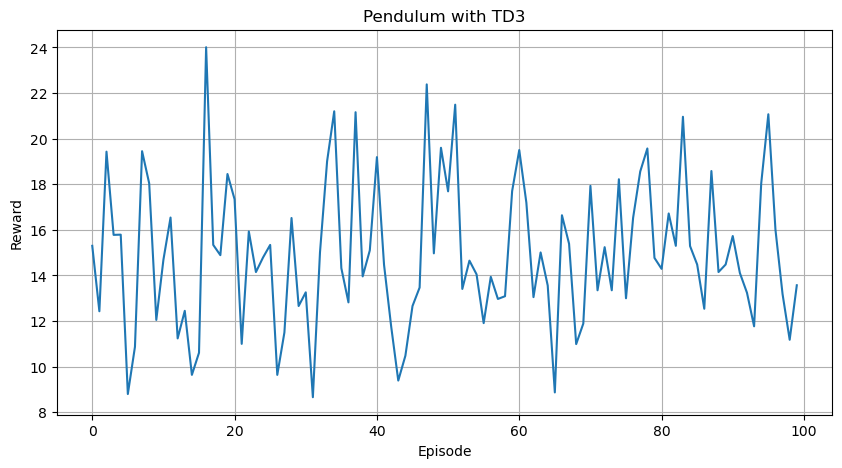

In [10]:
import matplotlib.pyplot as plt

rewards_average = []
for i in range(0,10000,100):
    rewards_average.append(np.mean(rewards[i: i+100]))


plt.figure(figsize=(10, 5))
plt.plot(rewards_average)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Pendulum with TD3')
plt.grid()
plt.show()

In [12]:
import pickle
dbfile = open('SAC_rewards_average.pkl', 'wb')
pickle.dump(rewards_average, dbfile)
dbfile.close()